## Is it a bird?

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

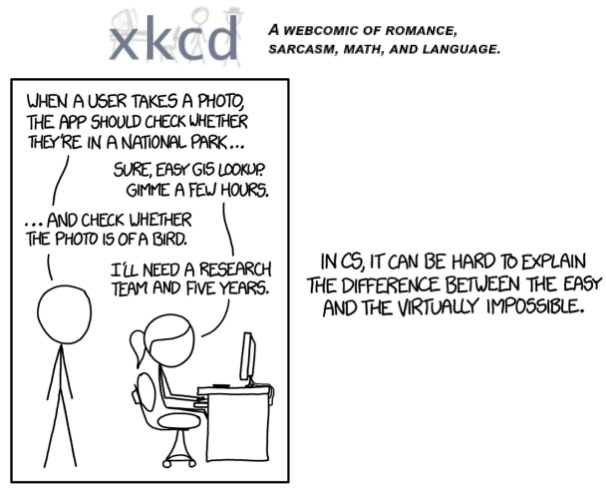

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 0: Install and import all dependencies

In [68]:
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai
!pip install -Uqq fastbook

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

from fastdownload import download_url


## Step 1: Download images of birds and non-birds

In [55]:
def search_images(term, max_images=200): 
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [56]:
urls = search_images('bird photos', max_images=1)
urls[0]

'http://2.bp.blogspot.com/-g9STQqFQ9Ik/UScse2IifqI/AAAAAAAAA08/mh1immEtVZo/s1600/bluebird.jpg'

...and then download a URL and take a look at it:

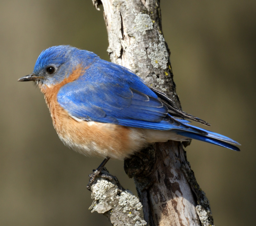

In [57]:
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

Now let's do the same with "forest photos":

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


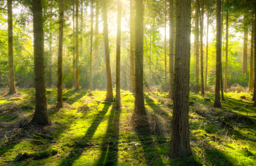

In [9]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [10]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

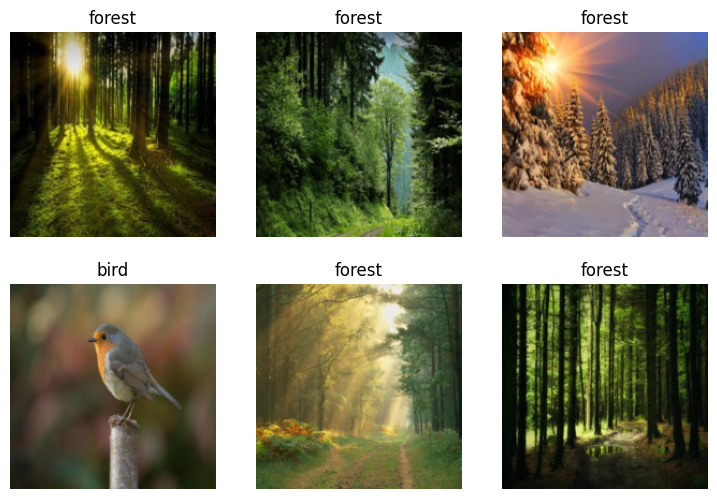

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.686837,0.348298,0.049020,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.113231,0.125393,0.019608,01:08
1,0.068011,0.095982,0.009804,01:09
2,0.049232,0.097516,0.009804,01:16


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

## What other tasks than Image Recognition?
### Image segmentation

We will use CAMVID_TINY dataset. But you can find other datasets and tasks under: https://docs.fast.ai/data.external.html 

In [62]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

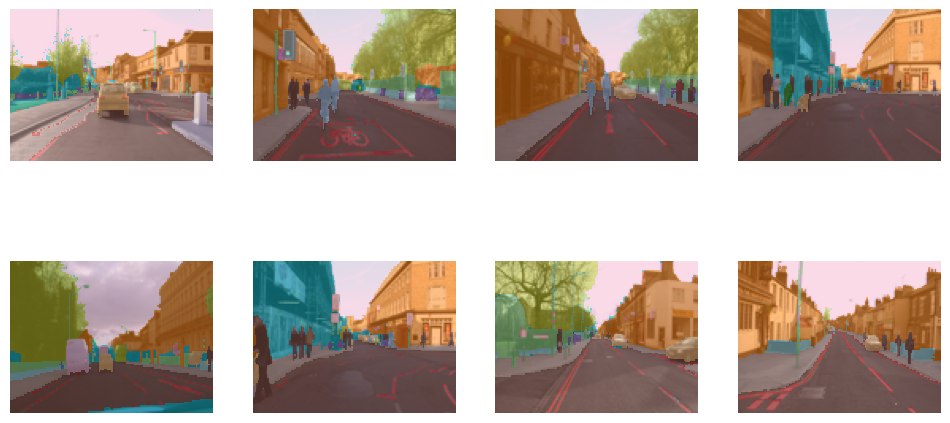

In [59]:
dls.show_batch()

In [60]:
learn = unet_learner(dls, resnet34)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


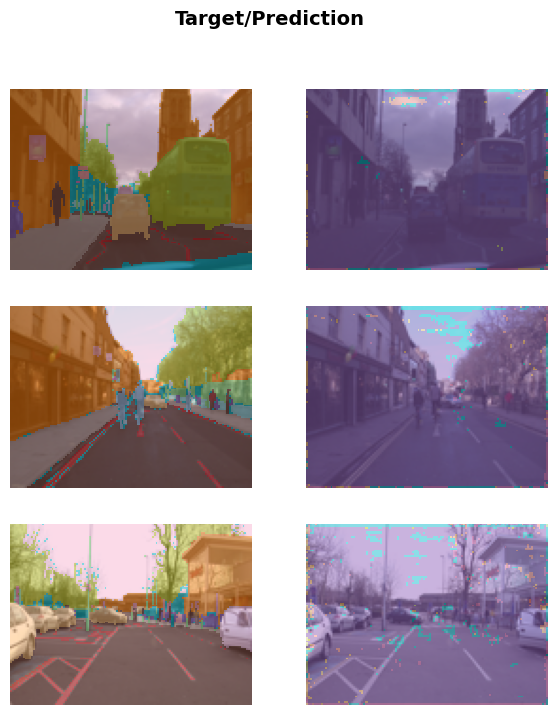

In [61]:
learn.show_results(max_n=3, figsize=(7,8))

### Lets fine-tune the model and see what it learns.

In [ ]:
learn.fine_tune(8)
learn.show_results(max_n=3, figsize=(7,8))

### Income prediction

We will use ADULT_SAMPLE dataset. But you can find other datasets and tasks under: https://docs.fast.ai/data.external.html 

In [64]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [65]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Bachelors,Divorced,Exec-managerial,Not-in-family,White,False,39.000000,181553.000365,13.0,<50k
1,Local-gov,Some-college,Married-civ-spouse,Protective-serv,Husband,White,False,35.000000,233327.000107,10.0,<50k
2,Private,HS-grad,Widowed,Machine-op-inspct,Not-in-family,White,False,60.000000,174486.000165,9.0,<50k
3,Private,Bachelors,Married-spouse-absent,Transport-moving,Unmarried,White,False,49.000000,402462.001462,13.0,<50k
4,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,35.000000,64922.003333,13.0,>=50k
5,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,36.000000,201117.000358,13.0,<50k
6,State-gov,Some-college,Never-married,Other-service,Not-in-family,White,False,19.000000,67216.999572,10.0,<50k
7,Private,HS-grad,Never-married,Machine-op-inspct,Own-child,White,False,18.000000,232081.999707,9.0,<50k
8,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,61.999999,197352.999870,9.0,<50k
9,Private,Some-college,Married-civ-spouse,Transport-moving,Husband,White,False,52.000000,145409.000026,10.0,>=50k


In [66]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.371071,0.353608,0.840602,00:09
1,0.359447,0.344042,0.843673,00:08


In [67]:
learn.show_results(max_n=3)

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,12.0,5.0,8.0,2.0,5.0,1.0,0.840193,1.049335,-0.428249,0.0,0.0
1,3.0,13.0,5.0,11.0,2.0,5.0,1.0,0.547069,-0.189117,1.528367,0.0,0.0
2,5.0,16.0,3.0,13.0,1.0,5.0,1.0,-0.039179,0.801063,-0.036925,1.0,1.0


### Colaborative filtering

We will use ML_SAMPLES dataset. But you can find other datasets and tasks under: https://docs.fast.ai/data.external.html 

In [39]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [40]:
dls.show_batch()

,userId,movieId,rating
0,262,780,1.5
1,111,2716,4.5
2,480,32,3.0
3,77,1200,4.0
4,580,296,4.5
5,346,1097,2.0
6,73,778,5.0
7,481,5952,4.0
8,119,2628,3.0
9,407,593,4.0


In [41]:
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.524390,1.367328,00:01


epoch,train_loss,valid_loss,time
0,1.381482,1.307111,00:00
1,1.267667,1.126523,00:01
2,1.017236,0.836804,00:01
3,0.798419,0.709154,00:00
4,0.687859,0.675053,00:01
5,0.648575,0.666844,00:00
6,0.628811,0.661029,00:00
7,0.615209,0.658764,00:01
8,0.607650,0.657905,00:01
9,0.610329,0.657782,00:00


In [42]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,70.0,33.0,3.5,3.482505
1,84.0,87.0,1.0,3.336112
2,66.0,84.0,2.0,4.092540
3,81.0,56.0,4.5,4.168121
4,91.0,47.0,5.0,3.179073
5,51.0,25.0,4.5,3.494047
6,89.0,82.0,1.0,4.213840
7,32.0,59.0,5.0,4.449821
8,86.0,33.0,2.5,3.170441


# Machine learning model at high-level

In [78]:
from fastbook import gv2
gv2('''program[shape=box3d width=2 height=1]
inputs->program->results''')


ExecutableNotFound: failed to execute Path('dot'), make sure the Graphviz executables are on your systems' PATH

In [79]:
gv2('''model[shape=box3d width=2 height=1]
inputs->model->results; weights->model''')

ExecutableNotFound: failed to execute Path('dot'), make sure the Graphviz executables are on your systems' PATH

In [80]:
gv2('''ordering=in
model[shape=box3d width=1.5 height=1]
inputs->model->results; weights->model; results->loss
loss->weights[constraint=false label=update]''')

ExecutableNotFound: failed to execute Path('dot'), make sure the Graphviz executables are on your systems' PATH

In [81]:
gv2('''model[shape=box3d width=2 height=1]
inputs->model->results''')

ExecutableNotFound: failed to execute Path('dot'), make sure the Graphviz executables are on your systems' PATH

# Homework

Play with it! Find task that is interesting to you. Pick up relevant dataset, fine-tune or train the model and share your results! You can explore using more classes, or other data-type for image recognition etc.